# Update Time Comparison

We compare the update time between the Apache DataSketches (ASF) HyperLogLog implementations alongside the `datasketch` HyperLogLogPlusPlus implementation.  The same hash function is used for both libraries.  We compare $4, 6, 8$ bit versions of the ASF implementations, showing that they have roughly equivalent update times which are all faster than the `datasketch` algorithm (which only provides support for $8$ bit HyperLogLog).  We compare the update time when the input is the same string of bytes for both sketches.

In [1]:
import sys
import argparse
from datetime import datetime
import pandas as pd
import numpy as np
from utils import distinct_number_sequence
import datasketches as ds
import datasketch as d
import mmh3
import os
import matplotlib.pyplot as plt
from timeit import default_timer
import warnings
%matplotlib inline

In [2]:
class UpdateTimeProfile:
    """Generates an experiment evaluating the update time for different cardinality inputs"""
    def __init__(self, sketch_lgk:int, lg_trials:int, max_lgN:int):
        self.sketch_lgk = sketch_lgk
        self.num_trials = 2**lg_trials
        self.max_lgN = max_lgN
        self.max_num_distincts = np.uint64(2 ** self.max_lgN)
        self.directory_name = "hll_update_time_profile_"
        if not os.path.exists(self.directory_name):
            os.mkdir(self.directory_name)
        self.file_extension = "_" + datetime.today().strftime('%H%M') + f"lgK_{self.sketch_lgk}_lgT_{lg_trials}"

        # Need to remove repeated items for the program logic in self.run()
        self.plot_points = self._generate_plot_points()
        self.plot_points.extend(self._generate_plot_points())
        self.plot_points = list(set(self.plot_points))
        self.plot_points.sort()
        print(f"Testing {len(self.plot_points)} points with {self.num_trials} trials for average update times:")
        print(self.plot_points)

        # Initialise the data structures for results; one for each method tested 8, 6, datasketch
        # np.ndarrays
        self.DataSketches_results_arr = np.zeros((len(self.plot_points), self.num_trials), dtype=float)
        self.DataSketches_results_arr_6 =  np.zeros_like(self.DataSketches_results_arr)
        self.DataSketches_results_arr_4 =  np.zeros_like(self.DataSketches_results_arr)
        self.datasketch_results_arr = np.zeros_like(self.DataSketches_results_arr)

        # pd.DataFrames
        self.DataSketches_results_df = pd.DataFrame(index=self.plot_points, columns=None)
        self.DataSketches_results_df_6 = pd.DataFrame(index=self.plot_points, columns=None)
        self.DataSketches_results_df_4 = pd.DataFrame(index=self.plot_points, columns=None)
        self.datasketch_results_df = pd.DataFrame(index=self.plot_points, columns=None)
        
        

    def _generate_plot_points(self) -> list:
        """
        Generates the standard sequence defining the input cardinalites for the experiment
        This is just two points at each power of 2
        """
        all_plot_points = []
        for lgk in range(1, self.max_lgN+1):
            points = np.unique(np.logspace(start=lgk, stop=lgk+1, num=4, endpoint=False, base=2, dtype=np.uint64))
            all_plot_points.extend(points)
        all_plot_points.sort()
        return all_plot_points

    def _is_power_of_two(self, a:np.uint64) -> bool:
        """Bitwise operations to check value a is a power of two"""
        return (a & (a-1) == 0) and a != 0

    def _results_to_df(self, start_:int, end_:int, arr:np.array, df:pd.DataFrame) -> pd.DataFrame:
        """Concatenates the array between columns start_,...end_ - 1 to the dataframe"""
        new_df = pd.DataFrame(arr[:, start_:end_], index=df.index, columns=np.arange(start_, end_).tolist())
        print("concatenating: ", new_df)
        concat_df = pd.concat([df, new_df], axis=1)
        return concat_df

    def run(self) -> None:
        """Runs the experiment and writes the files every power of two trials."""
        seq_start = np.uint64(2345234)
        distinct_number = np.uint64(3462)
        previous_log_trial_index = 0
        ds_all_results = np.zeros((self.num_trials, len(self.plot_points)))
        ds_all_results_6 = np.zeros_like(ds_all_results)
        ds_all_results_4 = np.zeros_like(ds_all_results)
        d_all_results = np.zeros_like(ds_all_results)

        for trial in range(1, self.num_trials+1):

            # Initialise the sketches
            hll = ds.hll_sketch(self.sketch_lgk, ds.HLL_8)
            hll6 = ds.hll_sketch(self.sketch_lgk, ds.HLL_6)
            hll4 = ds.hll_sketch(self.sketch_lgk, ds.HLL_4)
            h = d.HyperLogLogPlusPlus(p=self.sketch_lgk, hashfunc=lambda x: mmh3.hash64(x, signed=False)[0])
            plot_point_index = 0  # Return to the start of the plot points list to generate the data
            plot_point_value = self.plot_points[plot_point_index]
            total_updates = 0
            seq_start += distinct_number  # Start a new input sequence

            # Temporary result data structure
            ds_results = np.zeros((len(self.plot_points),))
            ds_results_6 = np.zeros_like(ds_results)
            ds_results_4 = np.zeros_like(ds_results)
            d_results = np.zeros_like(ds_results)


            for new_number in distinct_number_sequence(seq_start):
                d_input = new_number.tobytes()
                
                hll8_start = default_timer()
                hll.update(d_input)
                hll8_end = default_timer()

                hll6_start = default_timer()
                hll6.update(d_input)
                hll6_end = default_timer()

                hll4_start = default_timer()
                hll4.update(d_input)
                hll4_end = default_timer()

                d_start = default_timer()
                h.update(d_input)
                d_end = default_timer()
                total_updates += 1
                
                if total_updates == plot_point_value:
                    ds_results[plot_point_index]   =  hll8_end - hll8_start
                    ds_results_6[plot_point_index] =  hll6_end - hll6_start
                    ds_results_4[plot_point_index] =  hll4_end - hll4_start
                    d_results[plot_point_index]    =  d_end - d_start
                    plot_point_index += 1

                    if plot_point_index < len(self.plot_points):
                        plot_point_value = self.plot_points[plot_point_index]
                    else:
                        break

            # After the break statement, control returns here.  Now need to decide whether to write or continue.
            # subtract 1 as we use 1-based indexing for the trial count.
            ds_all_results[trial-1, :]   = ds_results 
            ds_all_results_6[trial-1, :] = ds_results_6 
            ds_all_results_4[trial-1, :] = ds_results_4
            d_all_results[trial - 1, :]  = d_results  
            if self._is_power_of_two(trial) and trial > 1:
                # write the array only a logarithmic number of times
                temporary_ds_results = ds_all_results[0:trial, : ]
                temporary_ds_results_6 = ds_all_results_6[0:trial, : ]
                temporary_ds_results_4 = ds_all_results_4[0:trial, : ]
                temporary_d_results = d_all_results[0:trial, :]
                print(f"#################### PARTIAL RESULTS FOR {trial} TRIALS: DATASKETCHES ####################")
                previous_log_trial_index = trial

                # Write 8 bit results
                self.DataSketches_results_df = pd.DataFrame(temporary_ds_results.T, 
                                                            index=self.DataSketches_results_df.index, 
                                                            columns=np.arange(trial).tolist())
                self.DataSketches_results_df.to_csv(
                    self.directory_name + "/DataSketches_hll" + self.file_extension + f"trials_{trial}_8_bit.csv",
                    index_label="n")

                # Write 6 bit results
                self.DataSketches_results_df_6 = pd.DataFrame(temporary_ds_results_6.T, 
                                                            index=self.DataSketches_results_df_6.index, 
                                                            columns=np.arange(trial).tolist())
                self.DataSketches_results_df_6.to_csv(
                    self.directory_name + "/DataSketches_hll" + self.file_extension + f"trials_{trial}_6_bit.csv",
                    index_label="n")

                 # Write 4 bit results
                self.DataSketches_results_df_4 = pd.DataFrame(temporary_ds_results_4.T, 
                                                            index=self.DataSketches_results_df_4.index, 
                                                            columns=np.arange(trial).tolist())
                self.DataSketches_results_df_4.to_csv(
                    self.directory_name + "/DataSketches_hll" + self.file_extension + f"trials_{trial}_4_bit.csv",
                    index_label="n")

                # Write datasketch results
                self.datasketch_results_df = pd.DataFrame(temporary_d_results.T,
                                                            index=self.datasketch_results_df.index,
                                                            columns=np.arange(trial).tolist())
                self.datasketch_results_df.to_csv(
                    self.directory_name + "/datasketch_hll" + self.file_extension + f"trials_{trial}.csv",
                    index_label="n"
                )
                print(self.DataSketches_results_df)

The experiment times all updates and saves the update time for particluar test points that are fixed for all trials.  The median of the written results are plotted and we evaluate the speedup between the libraries.

We set the default experimental parameters below.  If you need the example to run more quickly then you can run fewer trials.  Using 

```SKETCH_LGK = 12, LG_TRIALS = 5, MAX_LG_N = 21``` 

takes about $10$ minutes to run on a 2023 MacBook Pro with an Apple M1 Pro chip running Ventura 13.5.2. Absolute timings may vary slightly on different hardware.  

In [3]:
SKETCH_LGK = 12
LG_TRIALS = 5
MAX_LG_N = 21

In [4]:
update_experiment = UpdateTimeProfile(SKETCH_LGK, LG_TRIALS, MAX_LG_N)

Testing 81 points with 32 trials for average update times:
[2, 3, 4, 5, 6, 8, 9, 11, 13, 16, 19, 22, 26, 32, 38, 45, 53, 64, 76, 90, 107, 128, 152, 181, 215, 256, 304, 362, 430, 512, 608, 724, 861, 1024, 1217, 1448, 1722, 2048, 2435, 2896, 3444, 4096, 4870, 5792, 6888, 8192, 9741, 11585, 13777, 16384, 19483, 23170, 27554, 32768, 38967, 46340, 55108, 65536, 77935, 92681, 110217, 131072, 155871, 185363, 220435, 262144, 311743, 370727, 440871, 524288, 623487, 741455, 881743, 1048576, 1246974, 1482910, 1763487, 2097152, 2493948, 2965820, 3526975]


In [5]:
%%time
update_experiment.run()

/Users/charlied/dev/python-sketching-lib-comparison/datasketches-python/jupyter/comparison-to-datasketch/utils.py:27: RuntimeWarning: overflow encountered in scalar add
  num += np.uint64(golden_ratio)


#################### PARTIAL RESULTS FOR 2 TRIALS: DATASKETCHES ####################
                    0             1
2        1.166001e-06  7.089984e-07
3        1.162500e-05  7.499984e-07
4        1.000000e-06  3.583002e-06
5        8.329989e-07  7.499984e-07
6        8.749994e-07  7.499984e-07
...               ...           ...
1763487  7.079980e-07  7.079980e-07
2097152  7.079980e-07  7.090021e-07
2493948  7.499984e-07  7.500021e-07
2965820  7.089984e-07  7.089984e-07
3526975  6.669979e-07  7.079980e-07

[81 rows x 2 columns]


/Users/charlied/dev/python-sketching-lib-comparison/datasketches-python/jupyter/comparison-to-datasketch/utils.py:27: RuntimeWarning: overflow encountered in scalar add
  num += np.uint64(golden_ratio)


#################### PARTIAL RESULTS FOR 4 TRIALS: DATASKETCHES ####################
                    0             1             2             3
2        1.166001e-06  7.089984e-07  9.159994e-07  7.499984e-07
3        1.162500e-05  7.499984e-07  1.375000e-06  7.909985e-07
4        1.000000e-06  3.583002e-06  7.919989e-07  7.080016e-07
5        8.329989e-07  7.499984e-07  7.919989e-07  7.499984e-07
6        8.749994e-07  7.499984e-07  7.499984e-07  7.089984e-07
...               ...           ...           ...           ...
1763487  7.079980e-07  7.079980e-07  7.499984e-07  7.080016e-07
2097152  7.079980e-07  7.090021e-07  7.080016e-07  7.079980e-07
2493948  7.499984e-07  7.500021e-07  7.089984e-07  7.089984e-07
2965820  7.089984e-07  7.089984e-07  6.669979e-07  7.090021e-07
3526975  6.669979e-07  7.079980e-07  7.079980e-07  7.080016e-07

[81 rows x 4 columns]


/Users/charlied/dev/python-sketching-lib-comparison/datasketches-python/jupyter/comparison-to-datasketch/utils.py:27: RuntimeWarning: overflow encountered in scalar add
  num += np.uint64(golden_ratio)


#################### PARTIAL RESULTS FOR 8 TRIALS: DATASKETCHES ####################
                    0             1             2             3             4  \
2        1.166001e-06  7.089984e-07  9.159994e-07  7.499984e-07  8.339994e-07   
3        1.162500e-05  7.499984e-07  1.375000e-06  7.909985e-07  1.249999e-06   
4        1.000000e-06  3.583002e-06  7.919989e-07  7.080016e-07  7.909985e-07   
5        8.329989e-07  7.499984e-07  7.919989e-07  7.499984e-07  7.500021e-07   
6        8.749994e-07  7.499984e-07  7.499984e-07  7.089984e-07  7.500021e-07   
...               ...           ...           ...           ...           ...   
1763487  7.079980e-07  7.079980e-07  7.499984e-07  7.080016e-07  7.089984e-07   
2097152  7.079980e-07  7.090021e-07  7.080016e-07  7.079980e-07  7.079980e-07   
2493948  7.499984e-07  7.500021e-07  7.089984e-07  7.089984e-07  7.079980e-07   
2965820  7.089984e-07  7.089984e-07  6.669979e-07  7.090021e-07  7.500021e-07   
3526975  6.669979e-07  7

/Users/charlied/dev/python-sketching-lib-comparison/datasketches-python/jupyter/comparison-to-datasketch/utils.py:27: RuntimeWarning: overflow encountered in scalar add
  num += np.uint64(golden_ratio)


#################### PARTIAL RESULTS FOR 16 TRIALS: DATASKETCHES ####################
                   0             1             2             3             4   \
2        1.166001e-06  7.089984e-07  9.159994e-07  7.499984e-07  8.339994e-07   
3        1.162500e-05  7.499984e-07  1.375000e-06  7.909985e-07  1.249999e-06   
4        1.000000e-06  3.583002e-06  7.919989e-07  7.080016e-07  7.909985e-07   
5        8.329989e-07  7.499984e-07  7.919989e-07  7.499984e-07  7.500021e-07   
6        8.749994e-07  7.499984e-07  7.499984e-07  7.089984e-07  7.500021e-07   
...               ...           ...           ...           ...           ...   
1763487  7.079980e-07  7.079980e-07  7.499984e-07  7.080016e-07  7.089984e-07   
2097152  7.079980e-07  7.090021e-07  7.080016e-07  7.079980e-07  7.079980e-07   
2493948  7.499984e-07  7.500021e-07  7.089984e-07  7.089984e-07  7.079980e-07   
2965820  7.089984e-07  7.089984e-07  6.669979e-07  7.090021e-07  7.500021e-07   
3526975  6.669979e-07  

/Users/charlied/dev/python-sketching-lib-comparison/datasketches-python/jupyter/comparison-to-datasketch/utils.py:27: RuntimeWarning: overflow encountered in scalar add
  num += np.uint64(golden_ratio)


#################### PARTIAL RESULTS FOR 32 TRIALS: DATASKETCHES ####################
                   0             1             2             3             4   \
2        1.166001e-06  7.089984e-07  9.159994e-07  7.499984e-07  8.339994e-07   
3        1.162500e-05  7.499984e-07  1.375000e-06  7.909985e-07  1.249999e-06   
4        1.000000e-06  3.583002e-06  7.919989e-07  7.080016e-07  7.909985e-07   
5        8.329989e-07  7.499984e-07  7.919989e-07  7.499984e-07  7.500021e-07   
6        8.749994e-07  7.499984e-07  7.499984e-07  7.089984e-07  7.500021e-07   
...               ...           ...           ...           ...           ...   
1763487  7.079980e-07  7.079980e-07  7.499984e-07  7.080016e-07  7.089984e-07   
2097152  7.079980e-07  7.090021e-07  7.080016e-07  7.079980e-07  7.079980e-07   
2493948  7.499984e-07  7.500021e-07  7.089984e-07  7.089984e-07  7.079980e-07   
2965820  7.089984e-07  7.089984e-07  6.669979e-07  7.090021e-07  7.500021e-07   
3526975  6.669979e-07  

In [6]:
asf8 = pd.read_csv(f"hll_update_time_profile_/DataSketches_hll{update_experiment.file_extension}trials_32_8_bit.csv", index_col=0)
asf6 = pd.read_csv(f"hll_update_time_profile_/DataSketches_hll{update_experiment.file_extension}trials_32_6_bit.csv", index_col=0)
asf4 = pd.read_csv(f"hll_update_time_profile_/DataSketches_hll{update_experiment.file_extension}trials_32_4_bit.csv", index_col=0)
dsk = pd.read_csv(f"hll_update_time_profile_/datasketch_hll{update_experiment.file_extension}trials_32.csv", index_col=0)

In [7]:
# Plotting parameters
method_plot_params = {
    "asf8" : {"color": "C0", "marker": '.'},
    "asf6" : {"color": "C2", "marker": '+'},
    "asf4" : {"color": "C3", "marker": 'd'},
    "datasketch" : {"color": "C1", "marker": "^"}
}
asf8_color = method_plot_params["asf8"]["color"]
asf6_color = method_plot_params["asf6"]["color"]
asf4_color = method_plot_params["asf4"]["color"]
ds_color = method_plot_params["datasketch"]["color"]
q90_ls = "--"

params = {'legend.fontsize': 'x-large',
     'axes.labelsize': 'x-large',
     'axes.titlesize':'x-large',
     'xtick.labelsize':'x-large',
     'ytick.labelsize':'x-large',
      "lines.linewidth": 2.5}
plt.rcParams.update(params)

We plot on the $y$-axis the median update time (in microseconds) and $x$-axis the input cardinality on a $\log_{10}$ scale.
As expected, for both libraries, we see that the update time for a single item is essentially constant as $n$ increases, barring a small number of minor blips.

(6e-07, 1.6e-06)

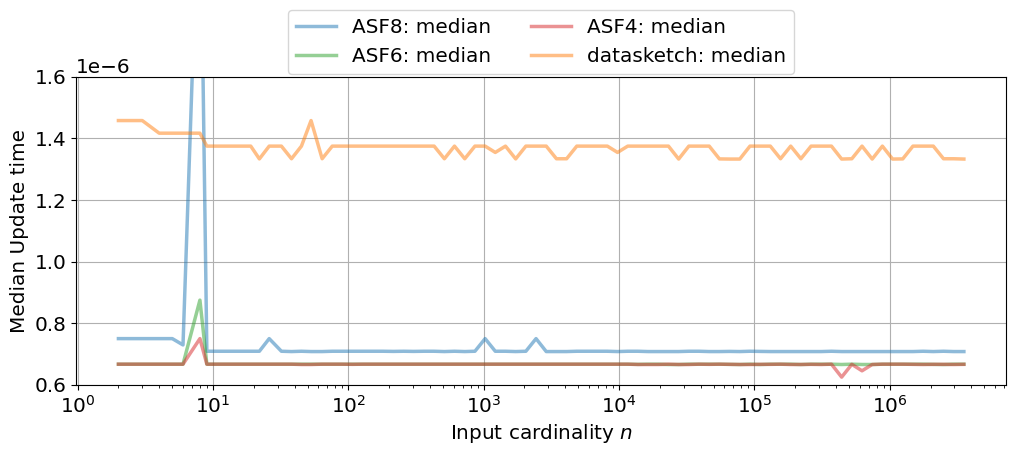

In [8]:
fig, ax = plt.subplots(figsize=(12,4))

methods = ["ASF8", "ASF6", "ASF4", "datasketch"]

for i, (method, colour, df) in enumerate(zip(methods, [asf8_color, asf6_color, asf4_color, ds_color], [asf8, asf6, asf4, dsk])):
    xn = df.index 
    median = df.median(axis=1)
    ax.plot(xn, median,
           color=colour, label=method+": median", alpha=0.5)

ax.set_xscale('log', base=10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=2, fancybox=True)
ax.grid()
ax.set_ylabel("Median Update time")
ax.set_xlabel(r"Input cardinality $n$")
ax.set_ylim(0.6E-6, 1.6E-6)

We evaluate the factor speedup per update.  This is defined as the ratio of the total time per update required in using the datasketch library compred to the ASF implementation.  We see that the datasketch library generally takes twice as much time per update compared to the ASF implementation.  Since there is essentially no difference between the $4, 6, 8$ bit versions of ASF HyperLogLog, we only plot the $8$ bit comparison below.

Text(0.5, 0, 'Input cardinality $n$')

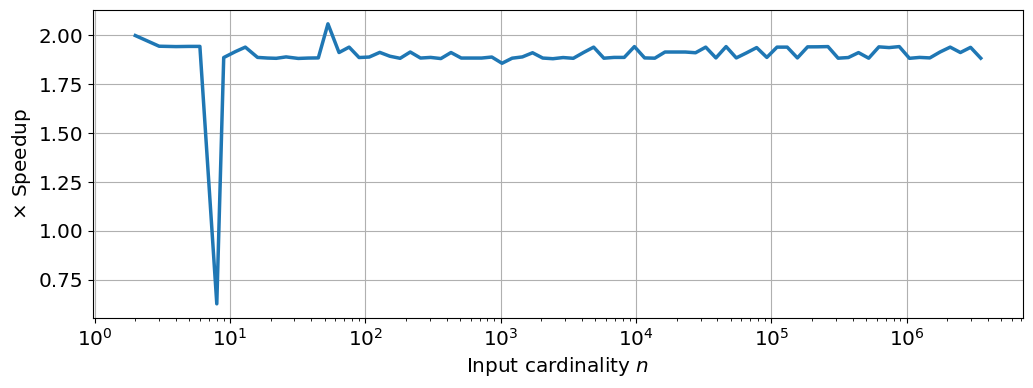

In [9]:
fig, ax = plt.subplots(figsize=(12,4))

methods = ["ASF8", "ASF6", "ASF4", "datasketch"]


xn = asf8.index
xspeedup = (dsk / asf8).median(axis=1)
ax.plot(xn, xspeedup)

ax.set_xscale('log', base=10)
ax.grid()
ax.set_ylabel(r"$\times$ Speedup")
ax.set_xlabel(r"Input cardinality $n$")
#ax.set_ylim(0.25E-6, 1.5E-6)